In [7]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [8]:

tk = th.Thicket.from_caliperreader(glob("cali2/*.cali"))
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")

tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size", "input_type"]).sort_index()
# Print the dataframe columns to check for input_type, input_size, and num_procs
print("Columns in dataframe:", tk.dataframe.columns)
# Print the head of the dataframe to verify structure
print(tk.dataframe.head())


(2/2) Creating Thicket: 100%|██████████| 251/251 [00:01<00:00, 243.18it/s]


Columns in dataframe: Index(['profile', 'nid', 'spot.channel', 'Min time/rank', 'Max time/rank',
       'Avg time/rank', 'Total time', 'Variance time/rank', 'Calls/rank (min)',
       'Calls/rank (avg)', 'Calls/rank (max)', 'Calls/rank (total)',
       'Min time/rank (exc)', 'Max time/rank (exc)', 'Avg time/rank (exc)',
       'Total time (exc)', 'name'],
      dtype='object')
                                                                                     profile  \
node                                         num_procs input_size input_type                   
{'name': 'MPI_Comm_dup', 'type': 'function'} 2         65536      perturbed       3855385893   
                                                                  random           783373523   
                                                                  reverse_sorted  1127830267   
                                                                  sorted          3245339270   
                                            

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


View Calltree

In [9]:
# Function to plot strong scaling for each input size
def plot_strong_scaling(df, input_size, title):
    plt.figure(figsize=(15, 7))
    
    for input_type in df.index.get_level_values('input_type').unique():
        subset = df.xs((input_size, input_type), level=('input_size', 'input_type'), drop_level=False)

        # Filter out non-positive values for plotting
        subset = subset[subset['Avg time/rank'] > 0]
        
        if not subset.empty:
            plt.plot(subset.index.get_level_values('num_procs'), subset['Avg time/rank'], label=f'{input_type}', marker='o')
    
    if pd.notna(input_size):
        input_size_str = f"$2^{{{int(np.log2(input_size))}}}$"
    else:
        input_size_str = "Unknown Size"

    plt.title(f"{title}: Strong Scaling (Input Size: {input_size_str})")
    plt.xlabel('Number of Processes')
    plt.ylabel('Avg Time per Rank (seconds)')
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_weak_scaling(df, input_type, title):
    plt.figure(figsize=(12, 6))
    
    # Filter data for the current input_type
    subset = df.xs(input_type, level='input_type', drop_level=False)

    # Get unique input sizes for plotting
    input_sizes = subset.index.get_level_values('input_size').unique()

    # Plot normalized weak scaling for each input size
    for size in input_sizes:
        size_subset = subset.xs(size, level='input_size', drop_level=False)
        
        # Group by number of processes and calculate mean time per rank
        mean_times = size_subset.groupby('num_procs')['Avg time/rank'].mean()

        # Normalize by the smallest mean time to show relative scaling
        initial_time = mean_times.iloc[0]
        normalized_times = mean_times / initial_time

        # Plot normalized times for the current input size
        plt.plot(normalized_times.index, normalized_times.values, label=f'Input Size $2^{{{int(np.log2(size))}}}$', marker='o')

    plt.title(f"{title}: Normalized Weak Scaling for {input_type.capitalize()} Input")
    plt.xlabel('Number of Processes')
    plt.ylabel('Normalized Avg Time per Rank')
    plt.xscale('log', base=2)
    plt.grid(True)
    plt.legend(title="Input Sizes")
    plt.show()







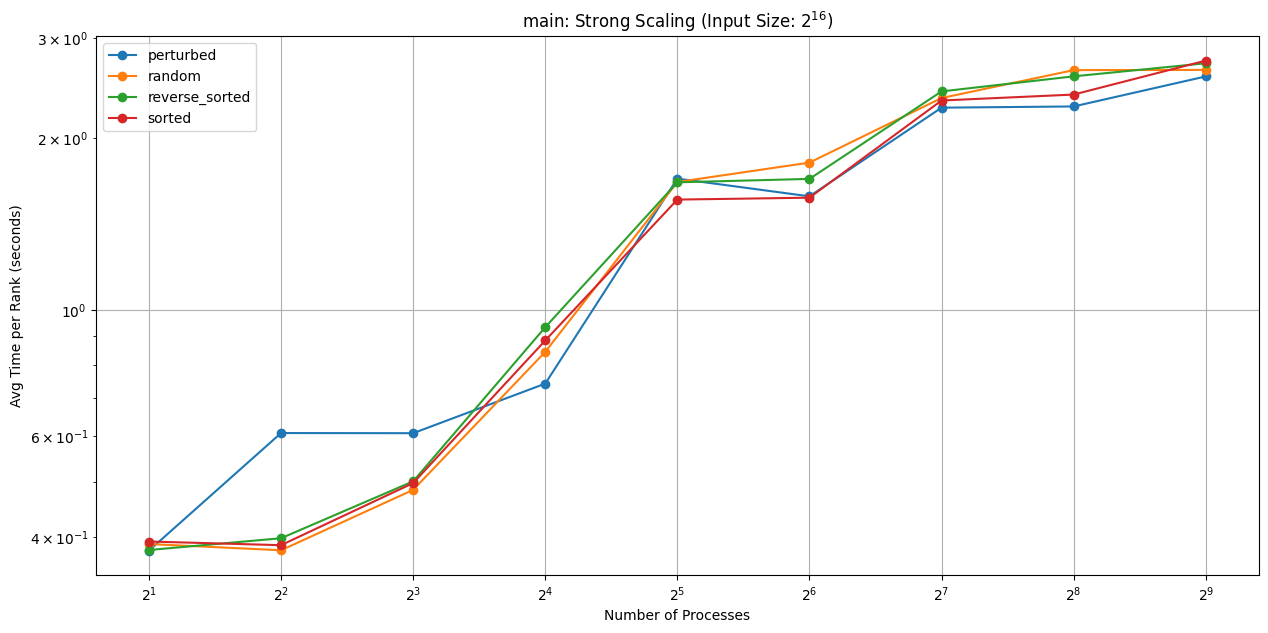

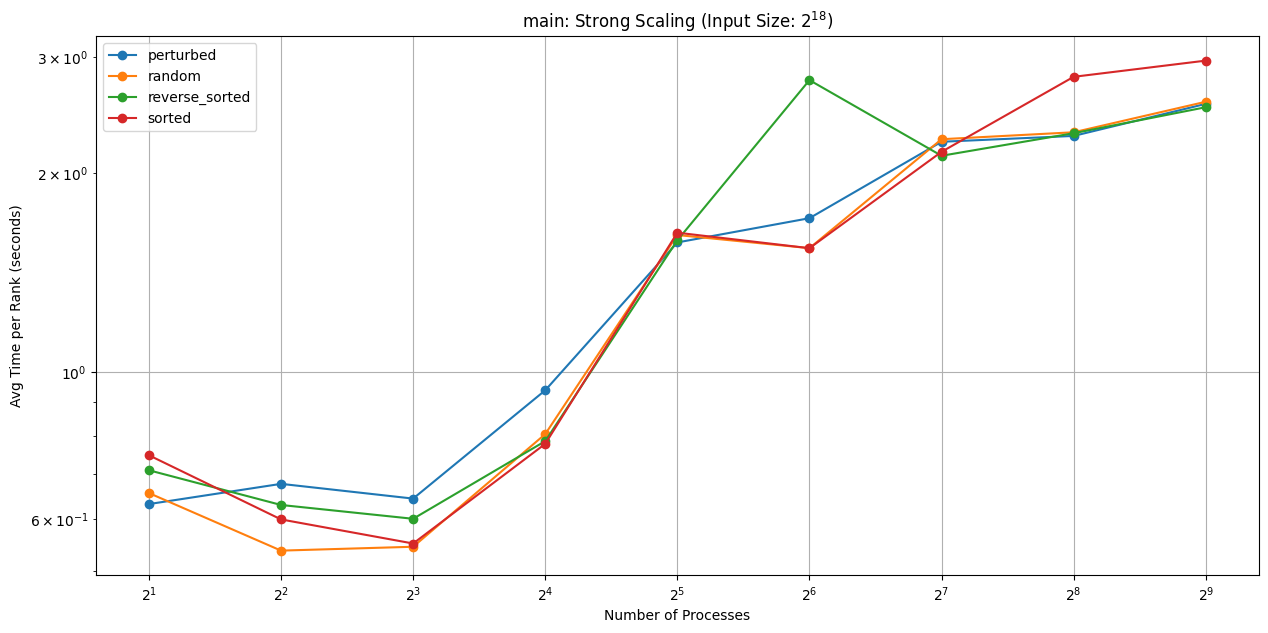

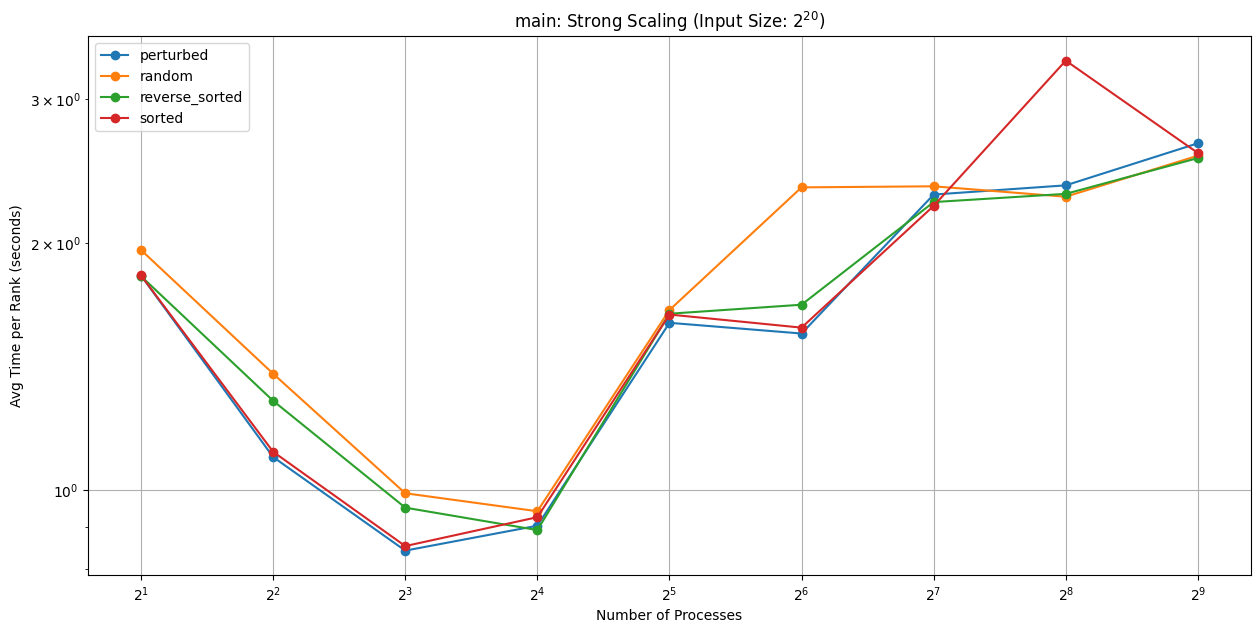

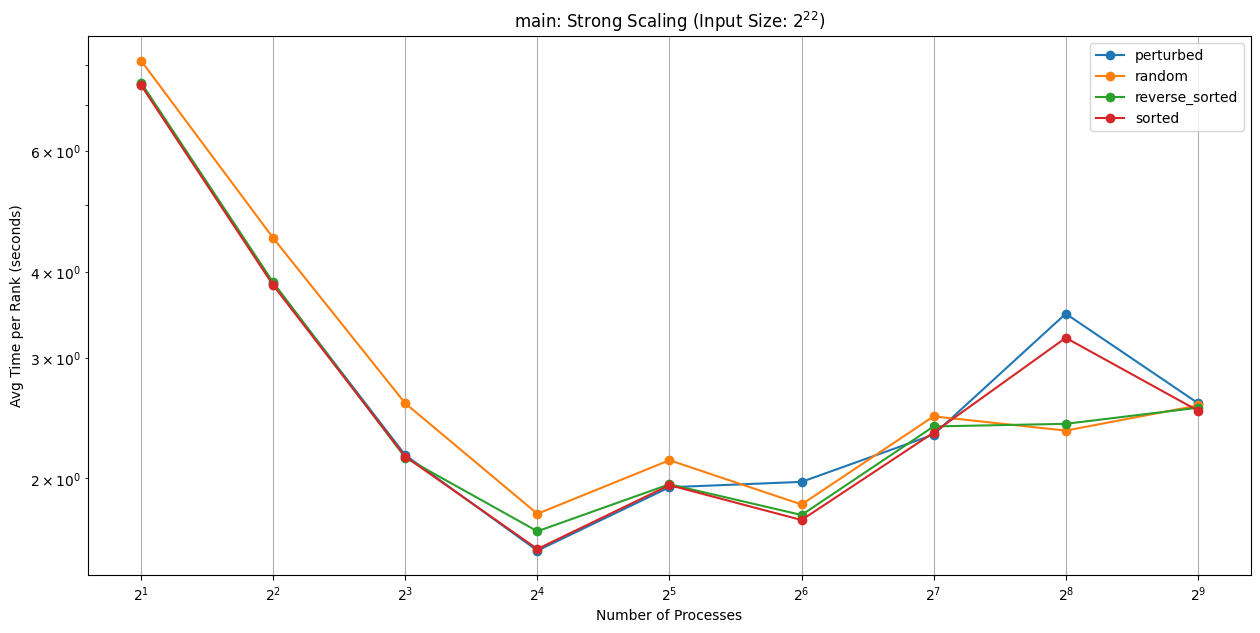

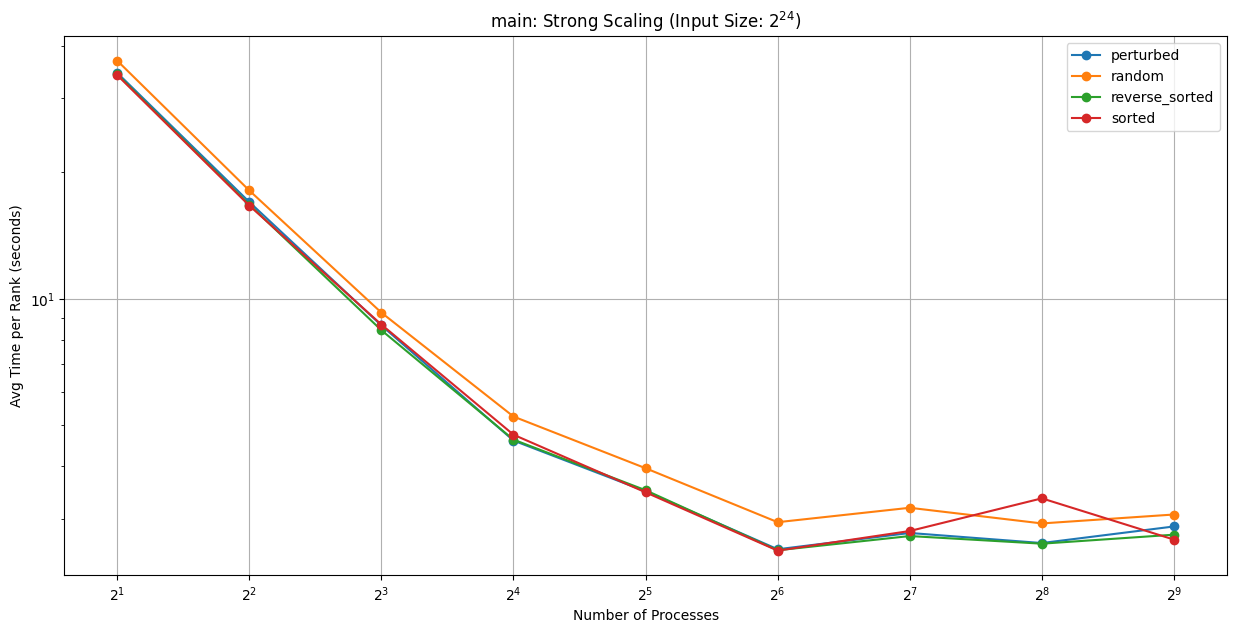

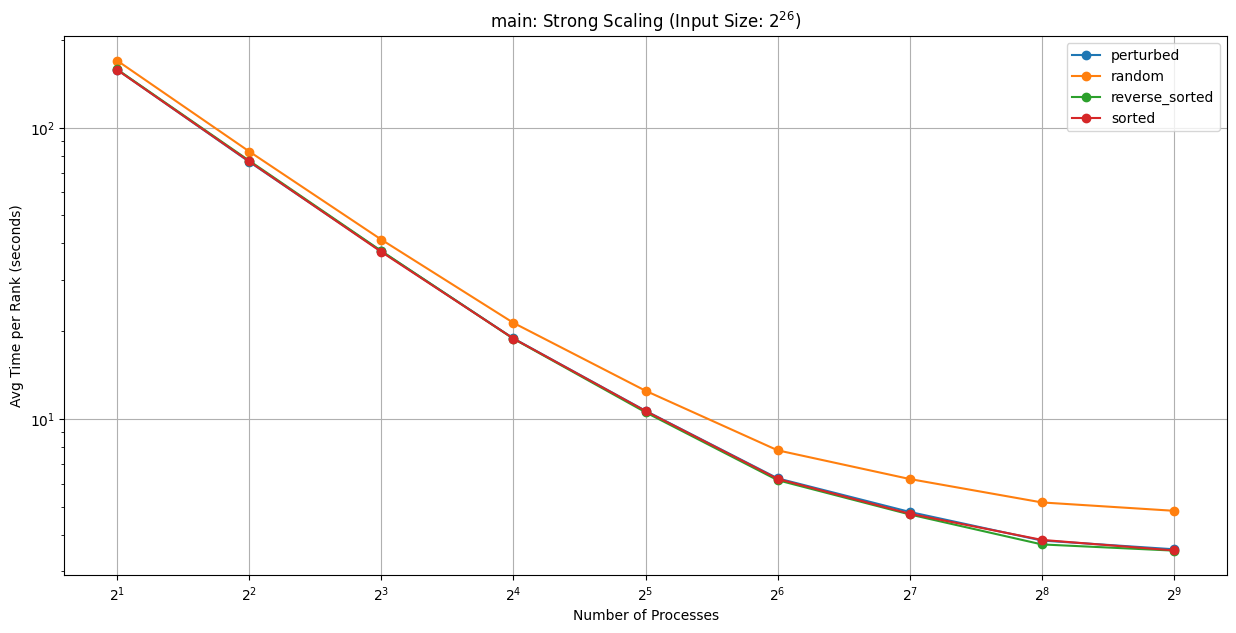

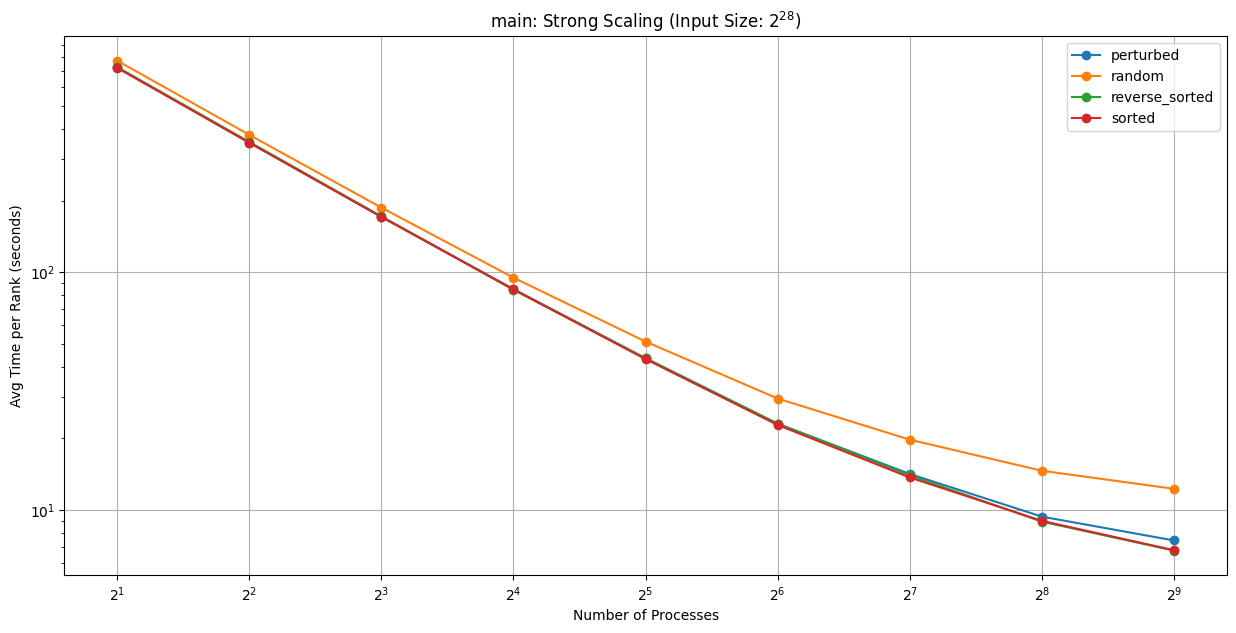

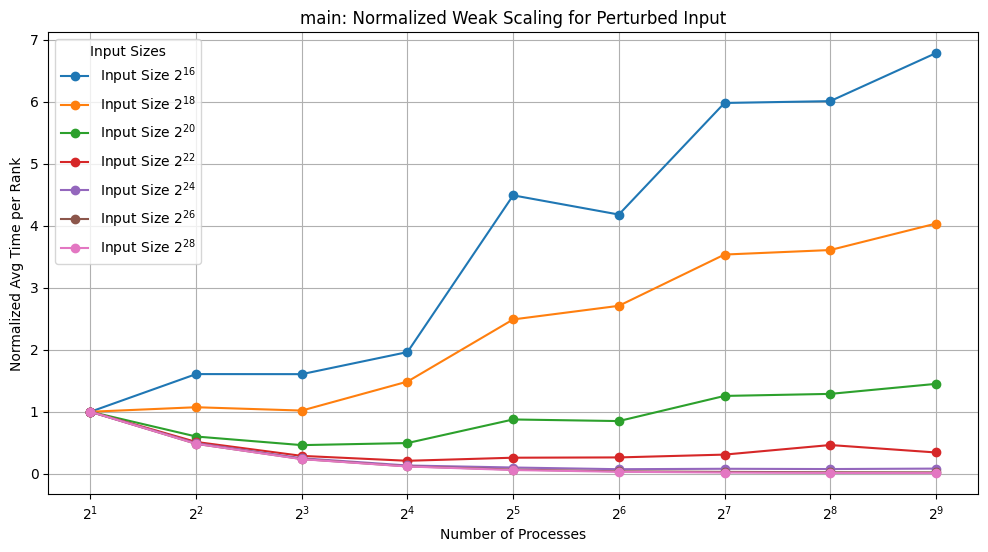

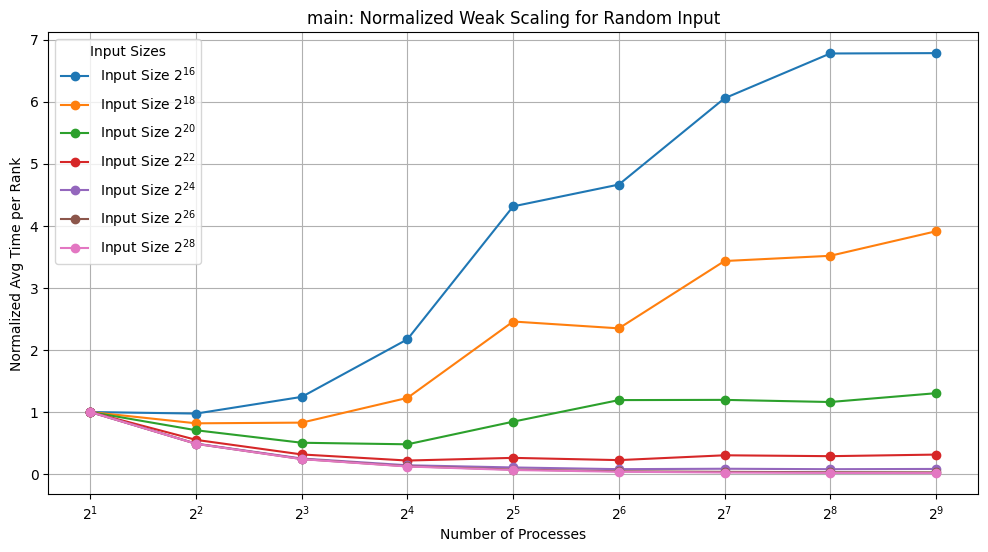

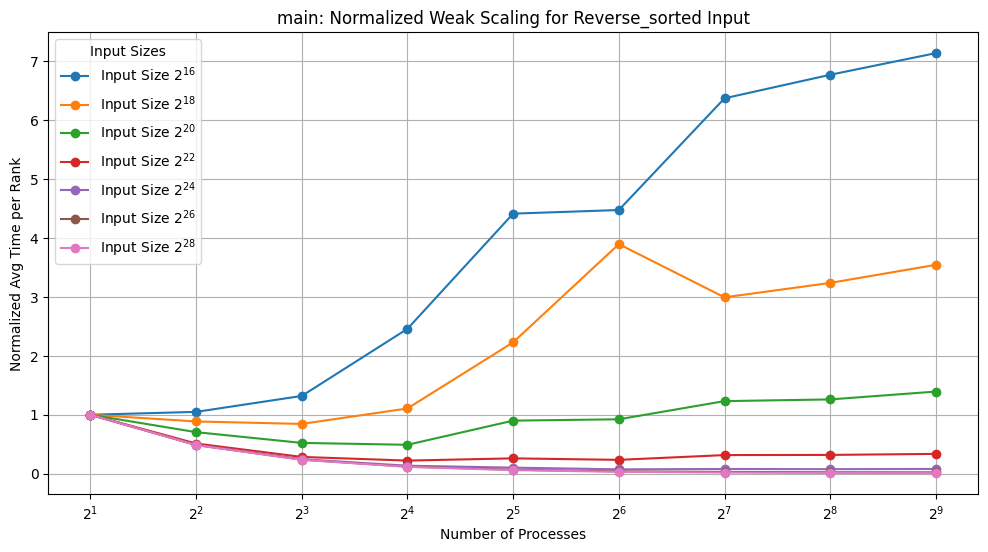

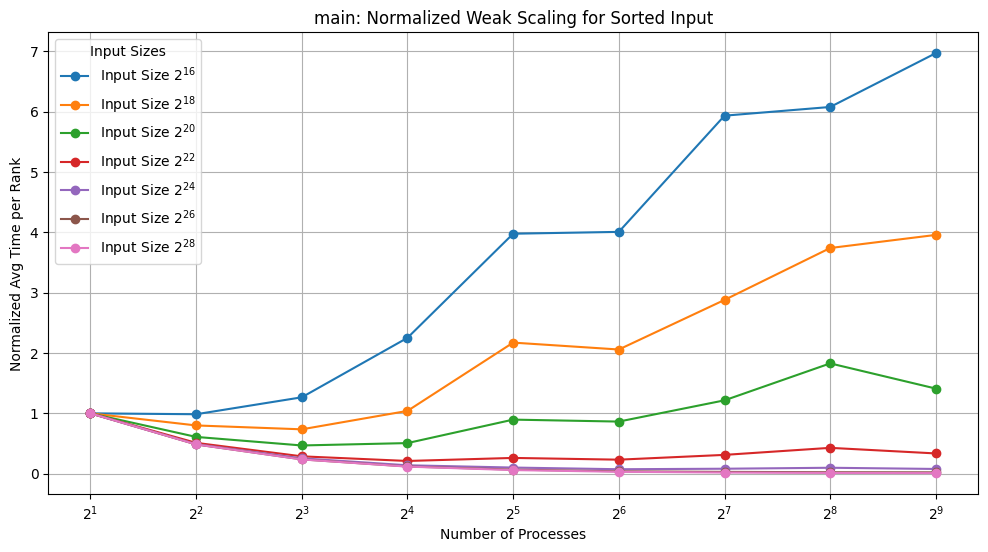

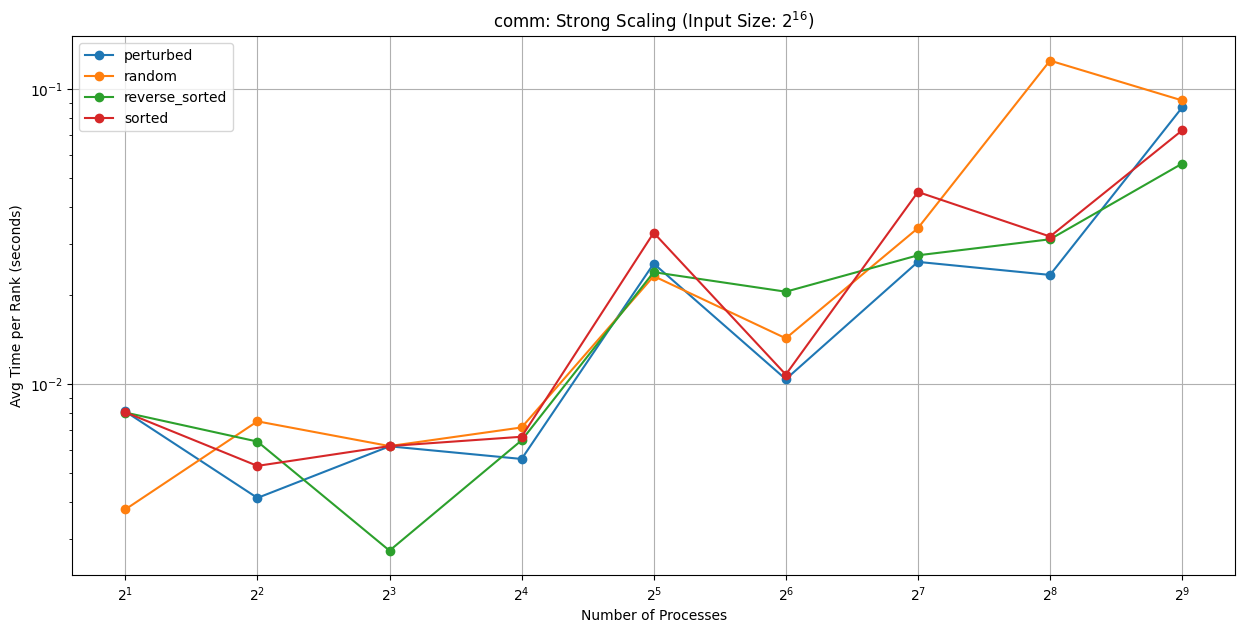

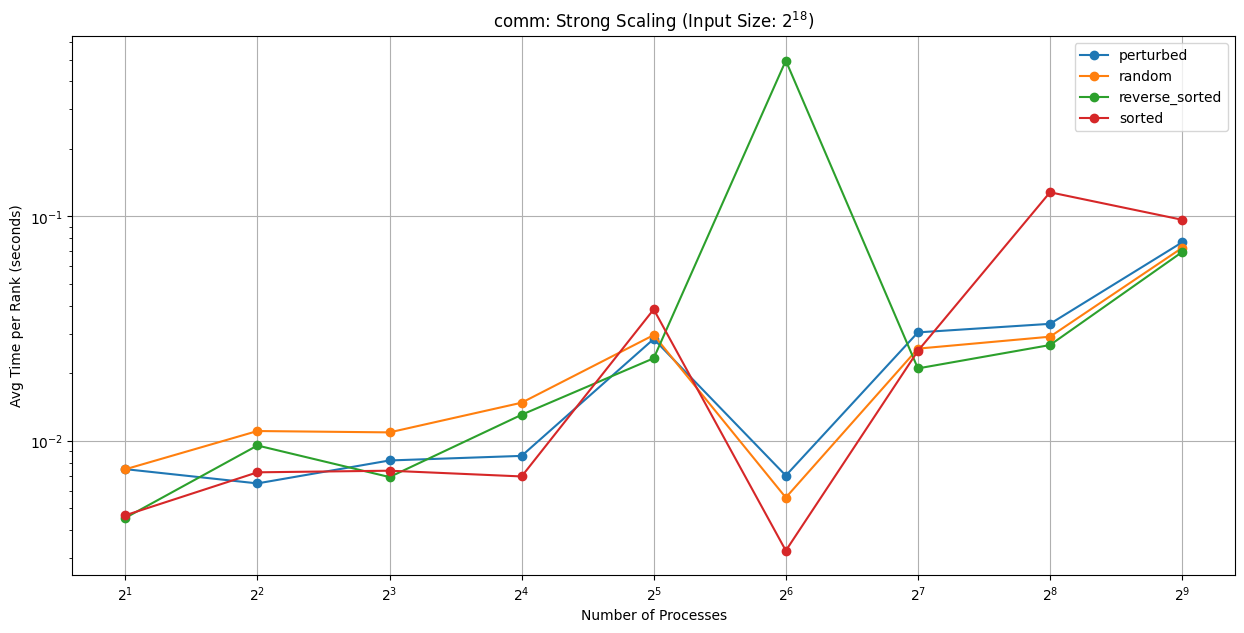

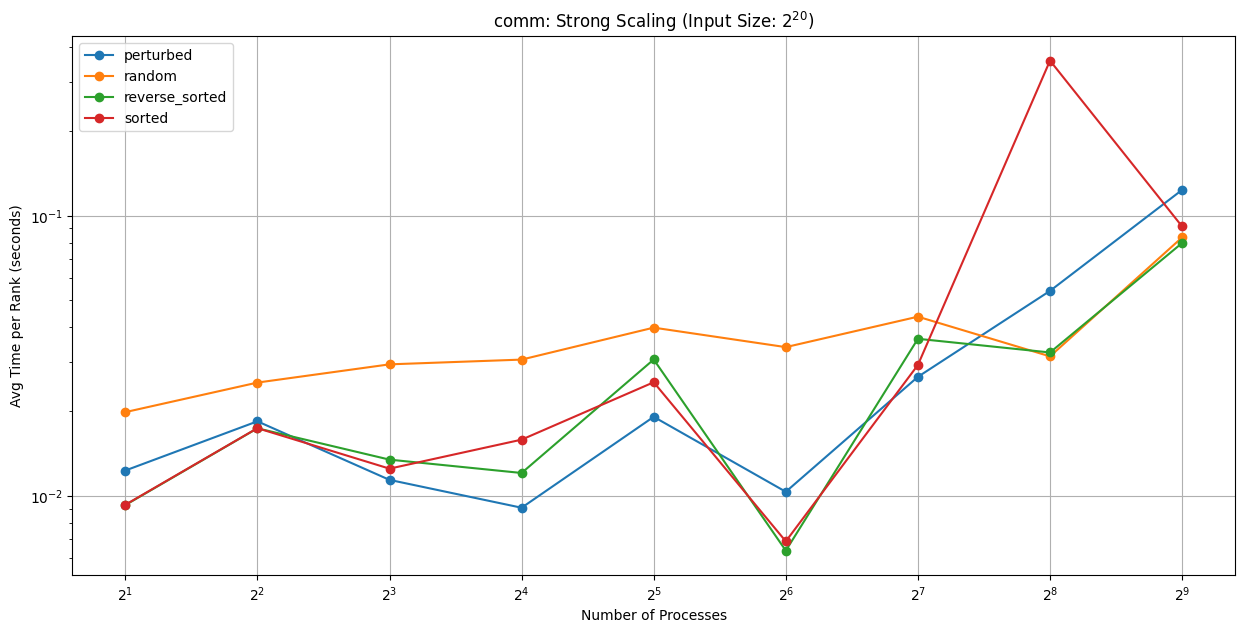

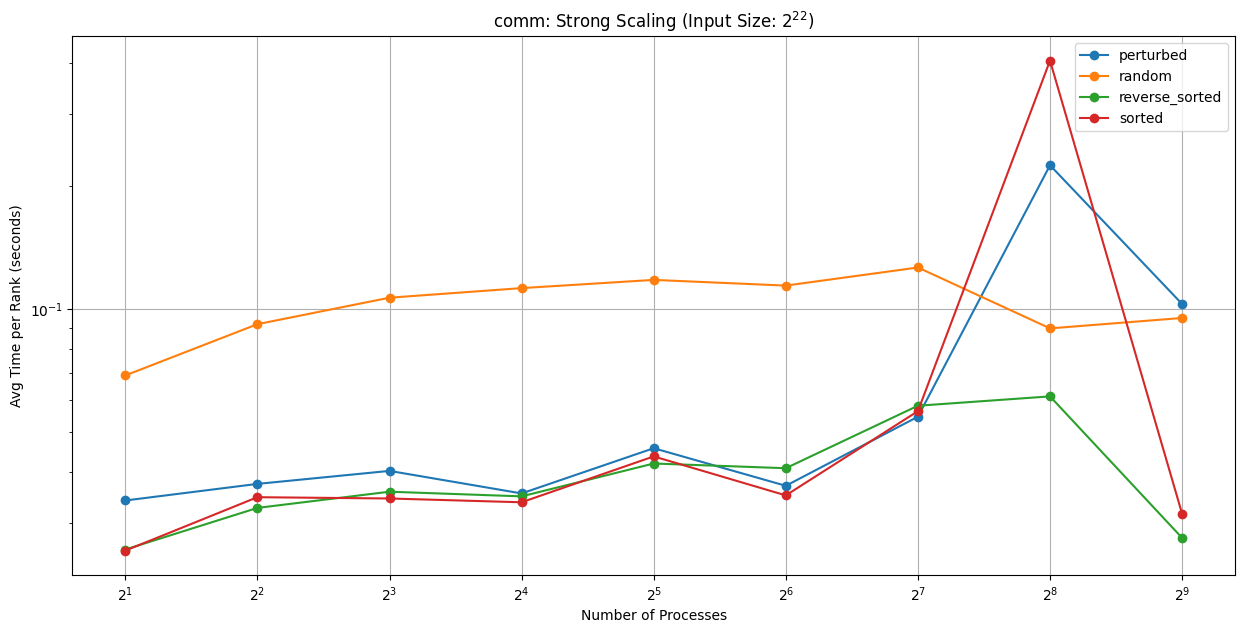

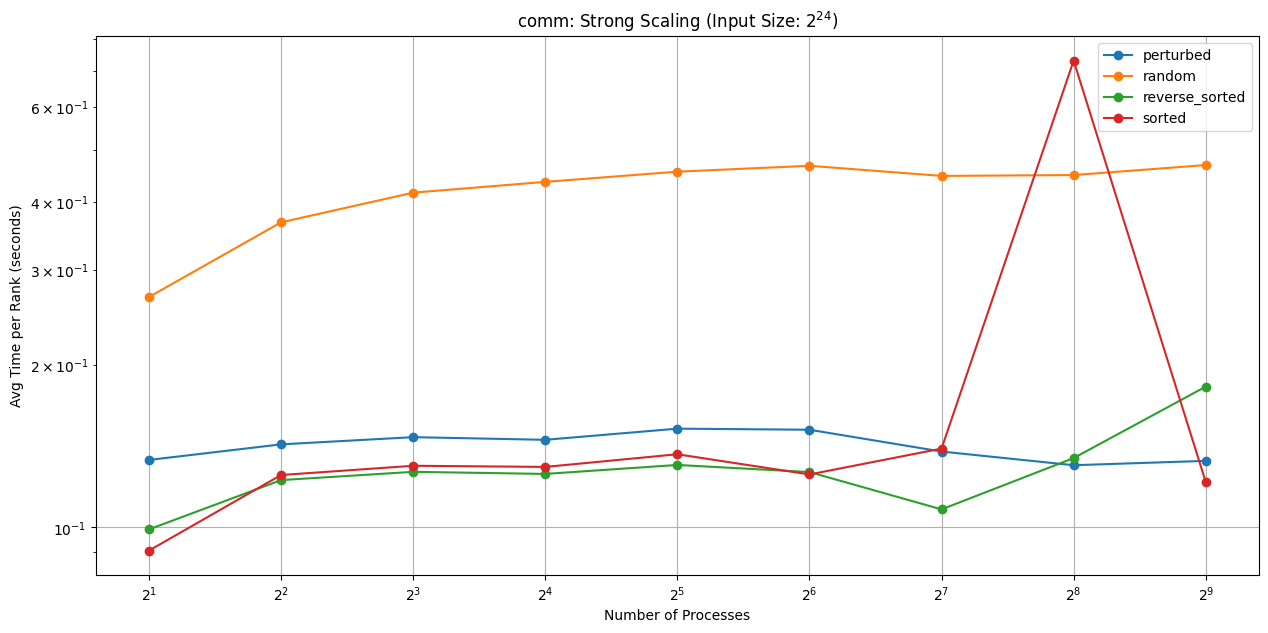

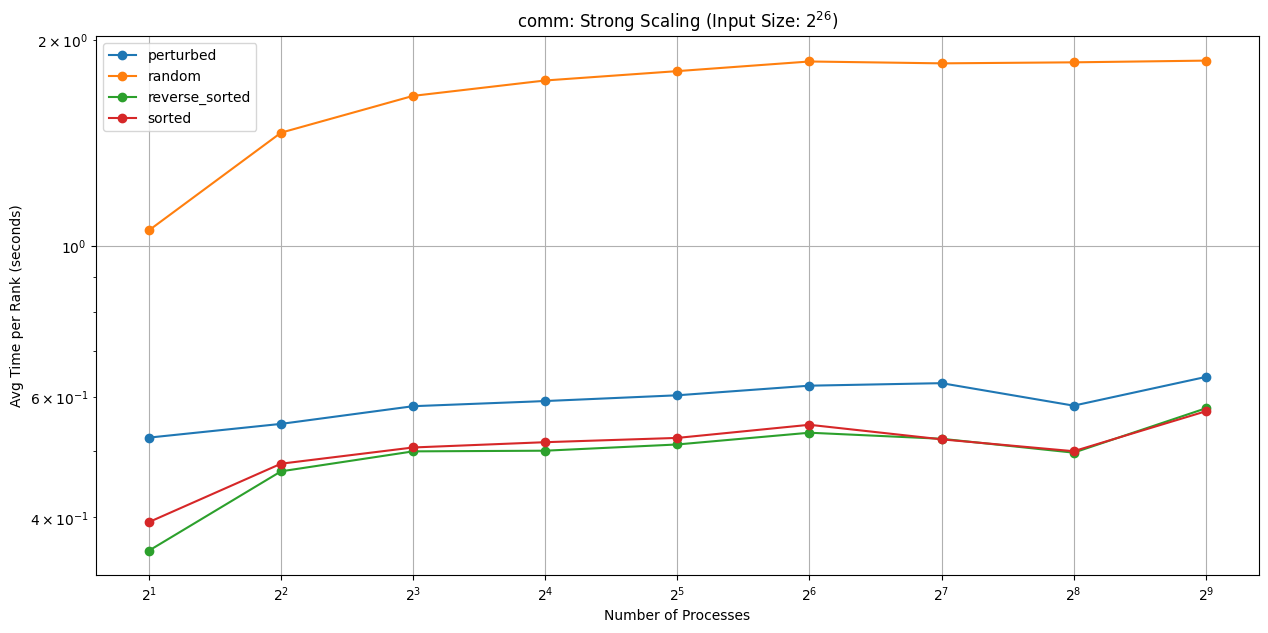

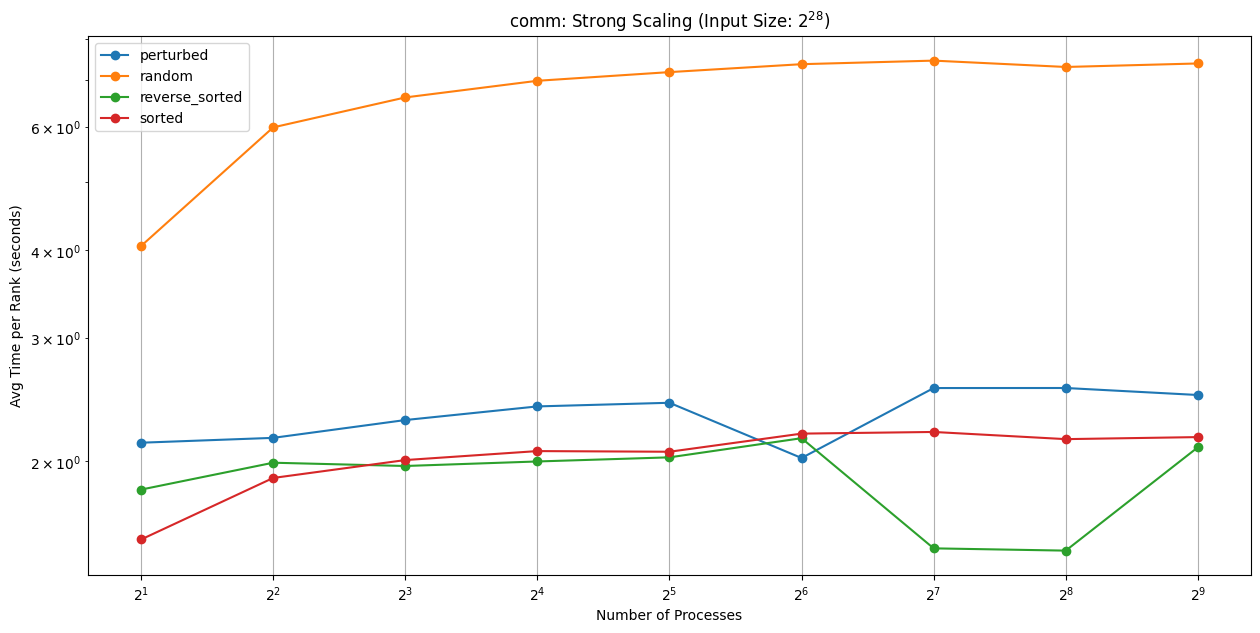

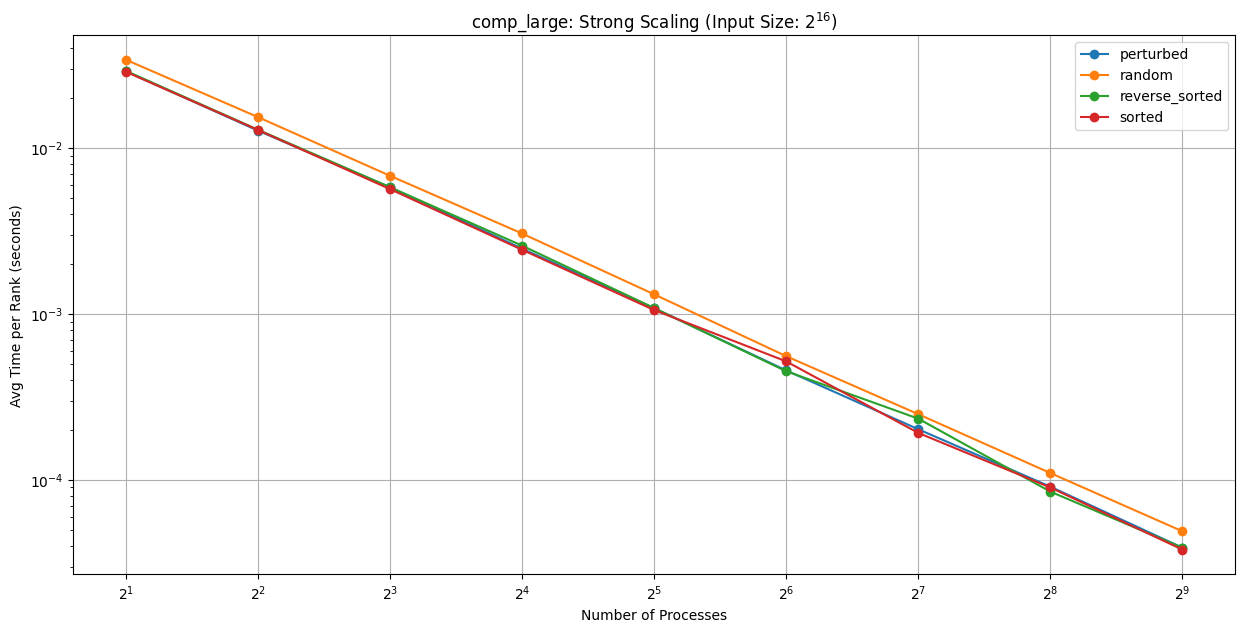

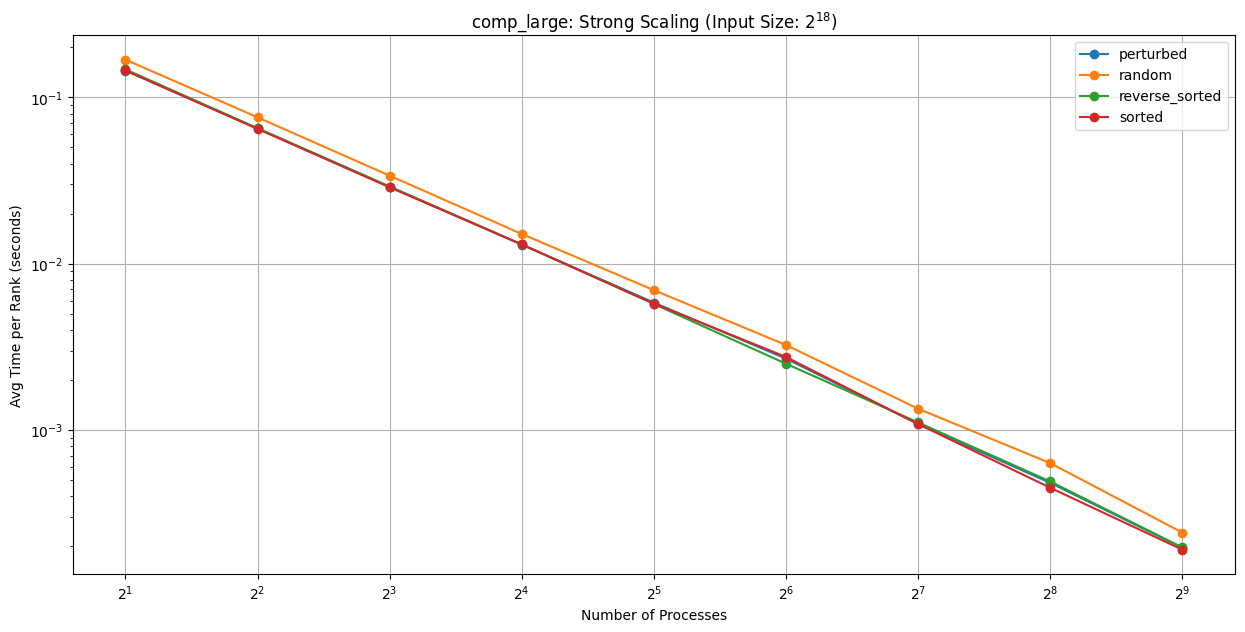

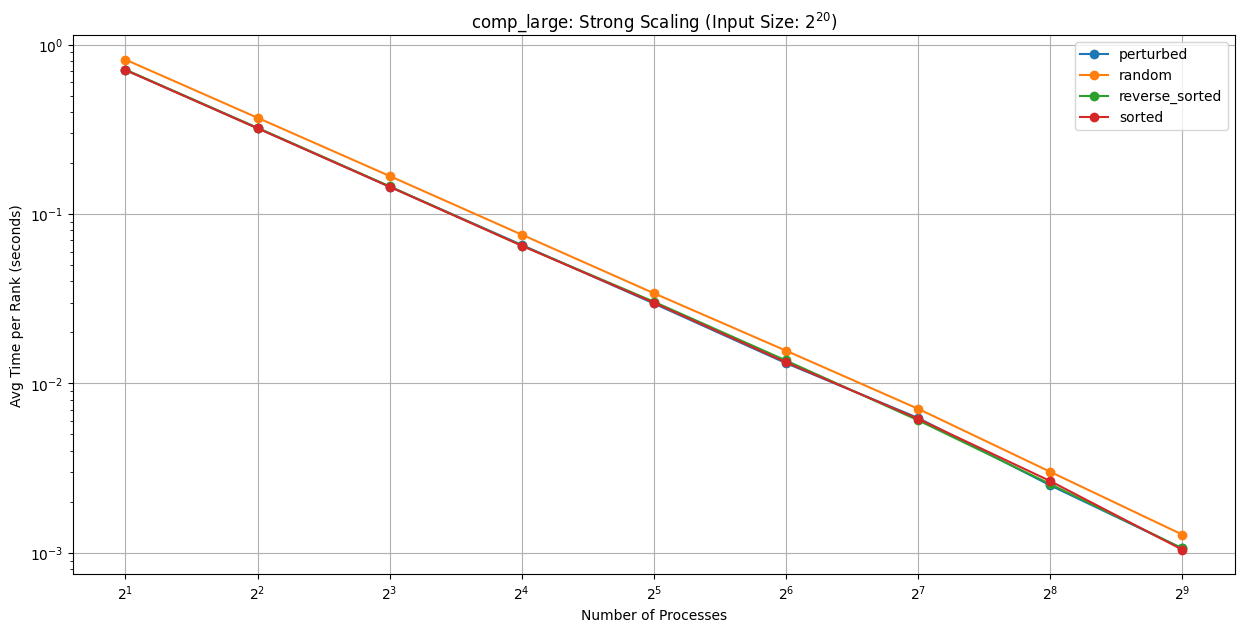

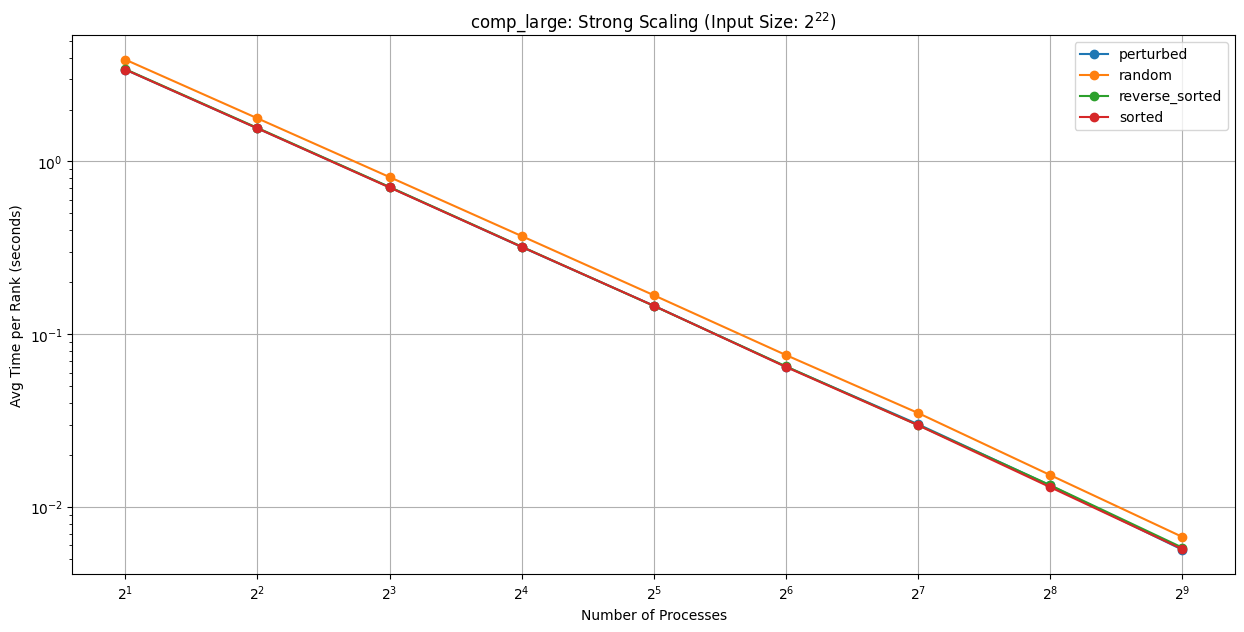

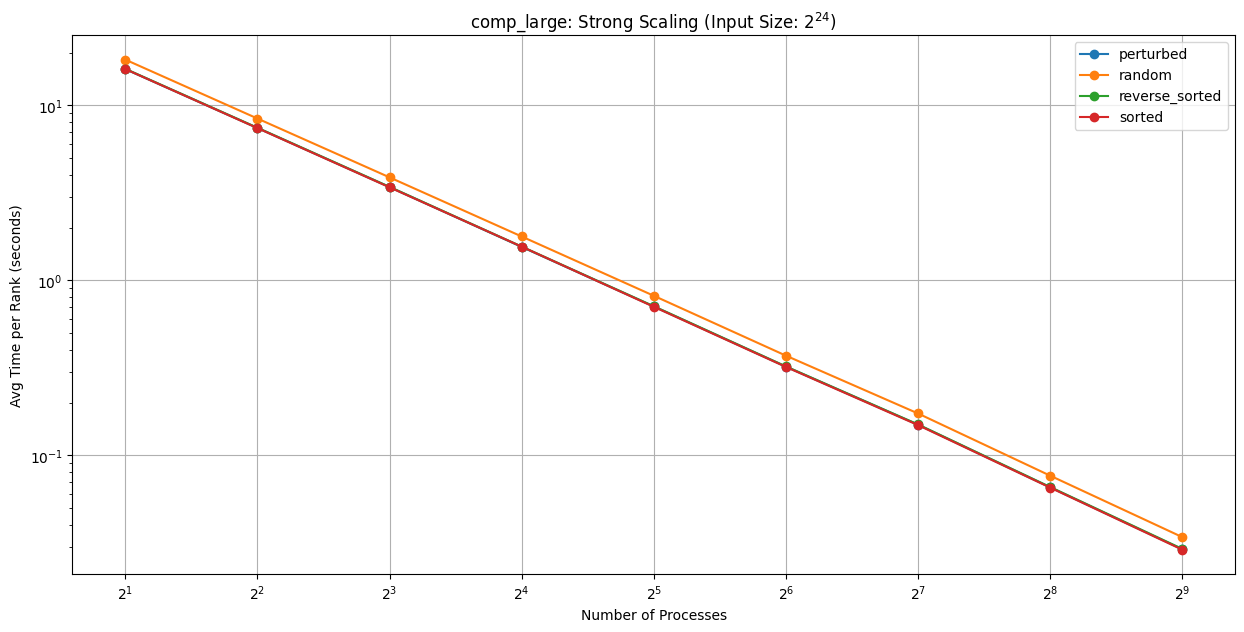

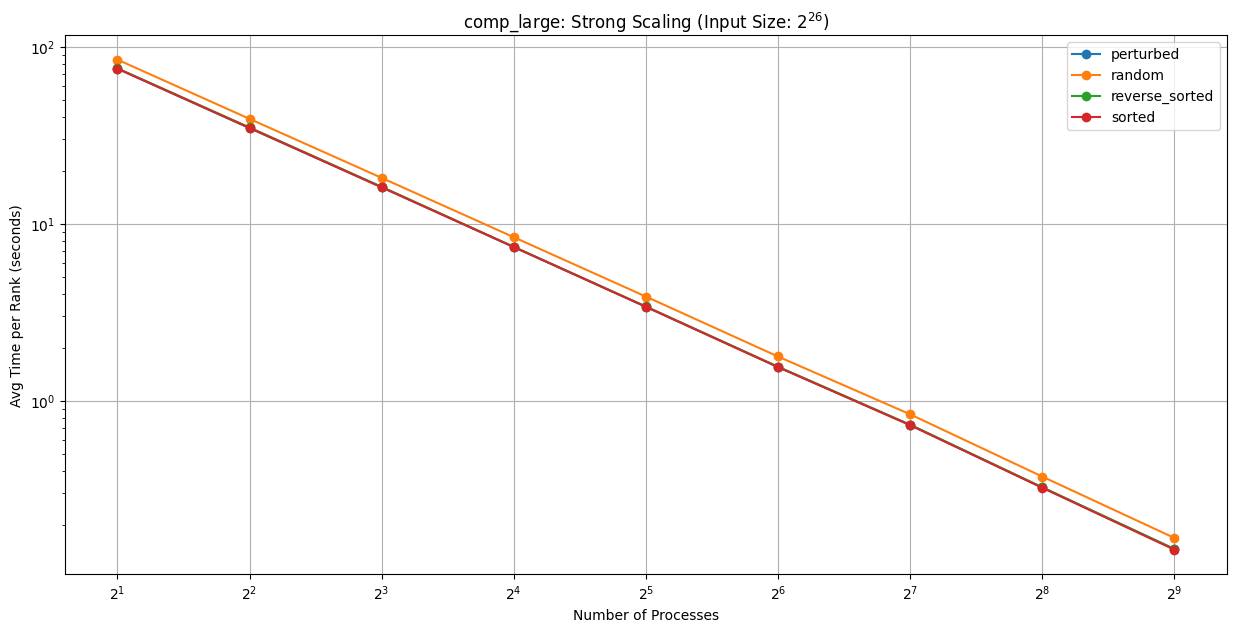

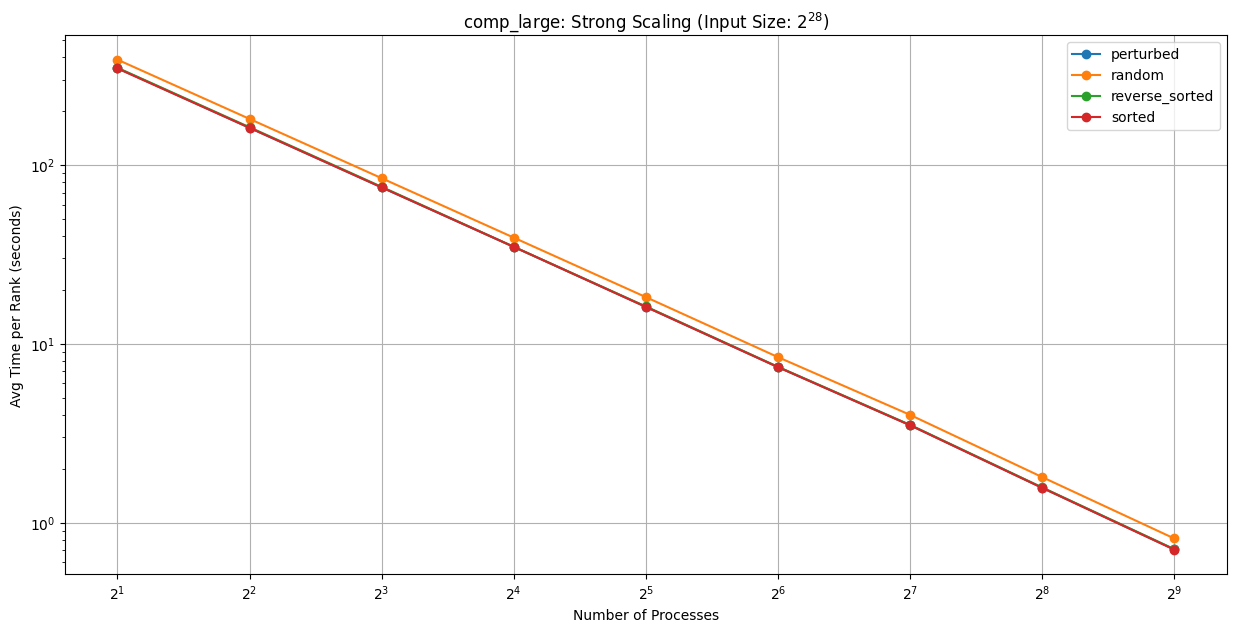

In [10]:
# Example of plotting for a specific function and implementation
for node in tk.graph.traverse():
    if node.frame['name'] == 'comp_large' or node.frame['name'] == 'comm' or node.frame['name'] == 'main':
        input_sizes = tk.dataframe.loc[node].index.get_level_values("input_size").unique()
        input_types = tk.dataframe.loc[node].index.get_level_values("input_type").unique()

        # Exclude 'NaN' and 'Random' from input_types
        input_types = [t for t in input_types if pd.notna(t) and t != 'Random']

        # Strong scaling plots for each input size
        for input_size in input_sizes:
            plot_strong_scaling(tk.dataframe.loc[node], input_size, node.frame['name'])
    if node.frame['name'] == 'main':  # Adjust if different function of interest
        input_types = tk.dataframe.loc[node].index.get_level_values("input_type").unique()
        for input_type in input_types:
            if pd.notna(input_type):
                plot_weak_scaling(tk.dataframe.loc[node], input_type, node.frame['name'])



(2/2) Creating Thicket: 100%|██████████| 251/251 [00:01<00:00, 246.56it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


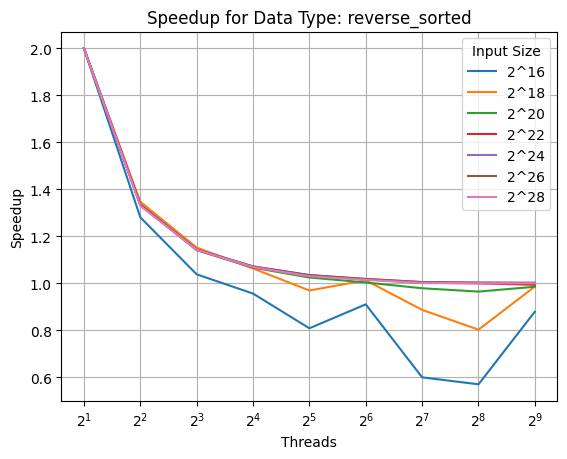

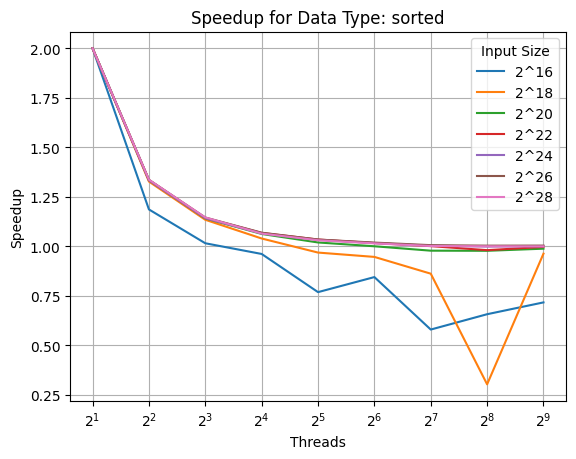

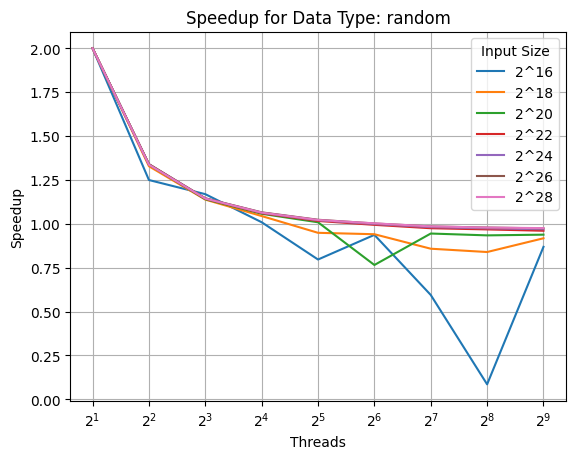

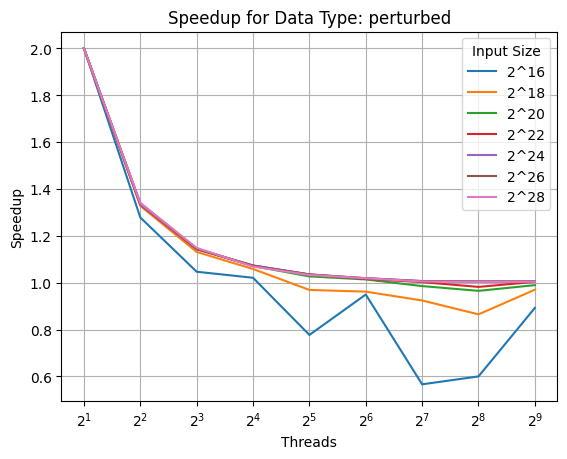

In [11]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import thicket as th

# Ensure pandas displays all rows/columns for easier inspection
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Load the performance data into a Thicket dataframe
cali_files = glob("cali2/*.cali")  # Adjust the path to where your cali files are located
tk = th.Thicket.from_caliperreader(cali_files)

tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_type")


# Define input sizes and thread counts (number of processes)
n_vals = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
thread_counts = [2, 4, 8, 16, 32, 64, 128, 256, 512]  # Replace with actual numbers of threads/ranks as needed
legends = ["2^16", "2^18", "2^20", "2^22", "2^24", "2^26", "2^28"]  # Legend labels for input sizes
data_types = ['reverse_sorted', 'sorted', 'random', 'perturbed']  # List of data types to filter

# Loop through each data type
for data_type in data_types:
    plt.figure()  # Create a new figure for each data type
    plt.title(f"Speedup for Data Type: {data_type}")  # Set the title for the plot

    # Loop through each input size to calculate and plot speedup
    for n_val, label in zip(n_vals, legends):
        # Filter the dataframe by input size and data type
        df_filtered = tk.dataframe[(tk.dataframe['input_size'] == n_val) & (tk.dataframe['input_type'] == data_type)]        
        # print(df_filtered.head())
        
        # Extract baseline time for 2 threads/processes
        baseline_rows = df_filtered[df_filtered['num_procs'] == 2]
        if baseline_rows.empty:
            print(f"No baseline data available for input size {n_val} with 2 processors and data_type {data_type}.")
            continue
        
        baseline_time = baseline_rows['Avg time/rank'].values[0]

        # Calculate speedup for each thread count
        speedup_values = []
        for threads in thread_counts:
            # Check if data for this number of threads exists
            thread_row = df_filtered[df_filtered['num_procs'] == threads]
            if not thread_row.empty:
                time_for_threads = thread_row['Avg time/rank'].values[0]
                speedup = 2 * baseline_time / time_for_threads
                speedup_values.append(speedup)
            else:
                speedup_values.append(None)  # Placeholder for missing data
                print(f"No data available for input size {n_val} with {threads} processors and data_type {data_type}.")

        # Plot speedup for current input size
        plt.plot(thread_counts, speedup_values, label=label)

    # Configure plot settings
    plt.xscale("log", base=2)  # Logarithmic scale for thread counts
    plt.xlabel("Threads")
    plt.ylabel("Speedup")
    plt.legend(title="Input Size")
    plt.grid(True)  # Optional: add grid for better visibility
    plt.show()  # Display the plot for the current data type

    

In [12]:
import pandas as pd

def export_process_time_csv(df, input_size=65536, input_type="random", mpi_function="main", output_file="process_time_data.csv"):
    """
    Exports the number of processes vs. time for a specified input size and input type to a CSV file.

    Parameters:
    - df: DataFrame containing Caliper data with 'input_size', 'input_type', 'num_procs', and 'Avg time/rank' columns.
    - input_size: Specific input size to filter (default is 2^16).
    - input_type: Specific input type to filter (default is 'random').
    - output_file: Name of the output CSV file (default is 'process_time_data.csv').
    """
    # Filter the data based on input size and input type
    filtered_df = df[(df['input_size'] == input_size) &
                     (df['input_type'] == input_type) &
                     (df['name'] == mpi_function)]

    print(filtered_df)
    
    # Check if there is any data available after filtering
    if filtered_df.empty:
        print(f"No data available for input size {input_size} and input type {input_type}.")
        return
    
    # Select only the columns for number of processes and average time per rank
    process_time_df = filtered_df[['num_procs', 'Total time']].sort_values(by='num_procs')



    # Save the result to a CSV file
    process_time_df.to_csv(output_file, index=False)
    print(f"Data successfully saved to {output_file}")

# Example usage with Caliper data DataFrame (tk.dataframe):
export_process_time_csv(df=tk.dataframe, input_size=65536, input_type="random", output_file="bitonic_sort_process_time.csv")
export_process_time_csv(df=tk.dataframe, input_size=67108864, input_type="random", output_file="bitonic_sort_process_time_big.csv")



                                                 nid   spot.channel  \
node                                 profile                          
{'name': 'main', 'type': 'function'} 65041958    1.0  regionprofile   
                                     327226500   1.0  regionprofile   
                                     439482792   1.0  regionprofile   
                                     783373523   1.0  regionprofile   
                                     790304768   1.0  regionprofile   
                                     2034486921  1.0  regionprofile   
                                     2213418601  1.0  regionprofile   
                                     2939095031  1.0  regionprofile   
                                     4254482123  1.0  regionprofile   

                                                 Min time/rank  Max time/rank  \
node                                 profile                                    
{'name': 'main', 'type': 'function'} 65041958         1.

In [13]:
import pandas as pd

def export_speedup_data_csv(df, input_size=65536, input_type="random", mpi_function="main", output_file="speedup_data.csv"):
    """
    Exports the speedup data for a specified input size, input type, and MPI function to a CSV file.

    Parameters:
    - df: DataFrame containing Caliper data with 'input_size', 'input_type', 'num_procs', 'Total time', and 'name' columns.
    - input_size: Specific input size to filter (default is 2^16).
    - input_type: Specific input type to filter (default is 'random').
    - mpi_function: Name of the MPI function to filter (default is 'MPI_Finalized').
    - output_file: Name of the output CSV file (default is 'speedup_data.csv').
    """
    # Filter the data based on input size, input type, and MPI function
    filtered_df = df[(df['input_size'] == input_size) &
                     (df['input_type'] == input_type) &
                     (df['name'] == mpi_function)]
    
    # Check if there is any data available after filtering
    if filtered_df.empty:
        print(f"No data available for input size {input_size}, input type {input_type}, and MPI function {mpi_function}.")
        return
    
    # Select only the relevant columns
    process_total_time_df = filtered_df[['num_procs', 'Total time']]
    
    # Calculate speedup based on the baseline time (using the minimum number of processes)
    baseline_time = process_total_time_df['Total time'].min()  # Get the baseline time
    process_total_time_df['Speedup'] = 2 * (baseline_time / process_total_time_df['Total time'])
    
    # Sort by number of processes
    process_total_time_df = process_total_time_df.sort_values(by='num_procs')

    # Save the result to a CSV file
    process_total_time_df.to_csv(output_file, index=False)
    print(f"Speedup data successfully saved to {output_file}.")

# Example usage with Caliper data DataFrame (tk.dataframe):
export_speedup_data_csv(df=tk.dataframe, input_size=65536, input_type="random", output_file="bitonic_sort_speedup_data.csv")

export_speedup_data_csv(df=tk.dataframe, input_size=67108864, input_type="random", output_file="bitonic_sort_speedup_data_big.csv")



Speedup data successfully saved to bitonic_sort_speedup_data.csv.
Speedup data successfully saved to bitonic_sort_speedup_data_big.csv.


/var/folders/f_/65mwh33j0mb_4f3z_y69__q80000gn/T/ipykernel_55248/1186992495.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_total_time_df['Speedup'] = 2 * (baseline_time / process_total_time_df['Total time'])
/var/folders/f_/65mwh33j0mb_4f3z_y69__q80000gn/T/ipykernel_55248/1186992495.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_total_time_df['Speedup'] = 2 * (baseline_time / process_total_time_df['Total time'])
